In [1]:
from glob import glob
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
import re
import nltk
from collections import defaultdict
from scipy import spatial

# Dataset Prep

In [2]:
df = pd.read_excel("InputTestSet-Reviews48_Ann.xlsx")

In [3]:
df.head()

,UID,PID,Dec,Sent,MComp,Cat,SubCat
0,0,2019_SJf_XhCqKm,Reject,The authors propose to use k-DPP to select a s...,0,NaN,NaN
1,1,2019_SJf_XhCqKm,Reject,"This paper covers the related work nicely, wit...",0,NaN,NaN
2,2,2019_SJf_XhCqKm,Reject,The rest of the paper are also clearly written.,0,NaN,NaN
3,3,2019_SJf_XhCqKm,Reject,"However, I have some concerns about the propos...",0,NaN,NaN
4,4,2019_SJf_XhCqKm,Reject,"- It is not clear how to define the kernel, th...",0,NaN,NaN


In [4]:
df.shape

(1505, 7)

In [5]:
gt_dict = {}

for i in range(0, df.shape[0]):
    pid = df.loc[i]["PID"]
    if not pid in gt_dict:
        gt_dict[pid] = {"dec": df.loc[i]["Dec"], "mcomp": set(), "not_mcomp": set()}
    if df.loc[i]["MComp"] == 1:
        gt_dict[pid]["mcomp"].add(df.loc[i]["UID"])
    else:
        gt_dict[pid]["not_mcomp"].add(df.loc[i]["UID"])

In [6]:
stats_dict = {"Accept": [0, 0], "Reject": [0, 0]}

for k, v in gt_dict.items():
    #print(len(v["mcomp"]), len(v["not_mcomp"]), v["dec"])
    stats_dict[v["dec"]][0] += len(v["mcomp"])
    stats_dict[v["dec"]][1] += len(v["not_mcomp"])
    
print(stats_dict)

{'Accept': [48, 644], 'Reject': [69, 744]}


In [7]:
test_set = list(gt_dict.keys())
print("TestSet length: %d\n"%len(test_set), test_set)

TestSet length: 32
 ['2019_SJf_XhCqKm', '2017_Bk0MRI5lg', '2020_SyevYxHtDB', '2018_rJBiunlAW', '2020_rkltE0VKwH', '2018_Hki-ZlbA-', '2019_BJx0sjC5FX', '2020_r1e_FpNFDr', '2020_B1lsXREYvr', '2018_SkZxCk-0Z', '2019_rJzoujRct7', '2018_HkfXMz-Ab', '2017_BJ9fZNqle', '2019_SyxZJn05YX', '2017_B1ckMDqlg', '2017_HJ0NvFzxl', '2017_S1_pAu9xl', '2018_SyYYPdg0-', '2017_BJAA4wKxg', '2019_HyVxPsC9tm', '2019_HylTBhA5tQ', '2019_B1l08oAct7', '2018_H135uzZ0-', '2017_H1oyRlYgg', '2017_r1y1aawlg', '2020_r1eX1yrKwB', '2020_Byg79h4tvB', '2019_H1lFZnR5YX', '2020_BkeWw6VFwr', '2018_HyHmGyZCZ', '2018_HyUNwulC-', '2020_HkgsPhNYPS']


In [8]:
for k in test_set:
    print('{:20}{}'.format(k, gt_dict[k]["mcomp"]))

2019_SJf_XhCqKm     {39, 17, 20, 27, 28, 30}
2017_Bk0MRI5lg      {48, 57}
2020_SyevYxHtDB     {76, 87}
2018_rJBiunlAW      {108, 110, 112, 113, 124, 126}
2020_rkltE0VKwH     {160, 155, 184, 159}
2018_Hki-ZlbA-      {267, 235, 236, 271}
2019_BJx0sjC5FX     {292, 287}
2020_r1e_FpNFDr     {312, 322, 315, 308}
2020_B1lsXREYvr     {376, 401}
2018_SkZxCk-0Z      {449, 443, 445, 486}
2019_rJzoujRct7     {518, 519}
2018_HkfXMz-Ab      {573, 566}
2017_BJ9fZNqle      {627, 623, 615}
2019_SyxZJn05YX     {672, 673, 657, 669, 671}
2017_B1ckMDqlg      {714, 707}
2017_HJ0NvFzxl      {739}
2017_S1_pAu9xl      {792, 809, 810, 806}
2018_SyYYPdg0-      {834, 867, 868, 869, 870, 872, 873, 844, 830}
2017_BJAA4wKxg      {884}
2019_HyVxPsC9tm     {931, 933, 905, 909, 912, 913, 919, 926}
2019_HylTBhA5tQ     {972, 950}
2019_B1l08oAct7     {994, 996, 1064, 1004, 1007, 1044, 1047, 1048, 1055}
2018_H135uzZ0-      {1072, 1079}
2017_H1oyRlYgg      set()
2017_r1y1aawlg      {1125, 1162, 1100, 1102, 1168}
2020_r1eX1y

In [9]:
sents_for_test = defaultdict(list)

for i in range(0, df.shape[0]):
    pid = df.loc[i]["PID"]
    sents_for_test[pid].append((df.loc[i]["UID"], df.loc[i]["Sent"]))

# A. SciBERT

In [10]:
import spacy
import torch

In [11]:
from transformers import AutoTokenizer, AutoModel

In [12]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_cased")

model = AutoModel.from_pretrained("allenai/scibert_scivocab_cased")

In [13]:
def embed_text_using_scibert(text):
    input_ids = torch.tensor(tokenizer.encode(text)).unsqueeze(0)  # Batch size 1
    outputs = model(input_ids)
    last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple
    return last_hidden_states

In [14]:
scibert_vectors = defaultdict(dict)
skip_uids = []

for pid in gt_dict:
    scibert_vectors[pid] = {}
    
    for mcs in gt_dict[pid]["mcomp"]:
        try:
            vec = embed_text_using_scibert(df.loc[mcs]["Sent"]).mean(1).detach().numpy()
            scibert_vectors[pid][mcs] = vec / norm(vec)
        except Exception as ex:
            print(pid, mcs, df.loc[mcs]["Sent"])
            skip_uids.append(mcs)
    
    for mcs in gt_dict[pid]["not_mcomp"]:
        try:
            vec = embed_text_using_scibert(df.loc[mcs]["Sent"]).mean(1).detach().numpy()
            scibert_vectors[pid][mcs] = vec / norm(vec)
        except Exception as ex:
            print(pid, mcs, df.loc[mcs]["Sent"])
            skip_uids.append(mcs)
        

2019_HyVxPsC9tm 938 2
2019_HyVxPsC9tm 940 3
2018_HyHmGyZCZ 1425 2


In [15]:
mcomp_sentences = {}
not_mcomp_sentences = {}

for pid in gt_dict:
    for mcs in gt_dict[pid]["mcomp"]:
        if not mcs in skip_uids:
            mcomp_sentences[mcs] = pid
    for mcs in gt_dict[pid]["not_mcomp"]:
        if not mcs in skip_uids:
            not_mcomp_sentences[mcs] = pid
print(len(mcomp_sentences), len(not_mcomp_sentences))

117 1385


In [16]:
sim_with_mcomp = defaultdict(dict)
sim_with_not_mcomp = defaultdict(dict)
sim_with_notmcomp_paper_sents = defaultdict(dict)
sim_with_mcomp_paper_sents = defaultdict(dict)

for sid in mcomp_sentences:
    
    # 1. With other mcomp sentences
    temp_list = []    
    for osid in mcomp_sentences:
        if osid != sid:
            temp_list.append(np.inner(scibert_vectors[mcomp_sentences[osid]][osid], scibert_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sim_with_mcomp[sid]["min"] = min(temp_list)
    sim_with_mcomp[sid]["max"] = max(temp_list)
    sim_with_mcomp[sid]["mean"] = np.mean(temp_list)
    
    
    # 2. With other not_mcomp_sentences
    temp_list = []
    for osid in not_mcomp_sentences:
        temp_list.append(np.inner(scibert_vectors[not_mcomp_sentences[osid]][osid], scibert_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sim_with_not_mcomp[sid]["min"] = min(temp_list)
    sim_with_not_mcomp[sid]["max"] = max(temp_list)
    sim_with_not_mcomp[sid]["mean"] = np.mean(temp_list)
    
    # 3. With not_mcomp_sentences of the same paper
    temp_list = []    
    for osid in not_mcomp_sentences:
        if not_mcomp_sentences[osid] == mcomp_sentences[sid]:
            temp_list.append(np.inner(scibert_vectors[not_mcomp_sentences[osid]][osid], scibert_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sim_with_notmcomp_paper_sents[sid]["min"] = min(temp_list)
    sim_with_notmcomp_paper_sents[sid]["max"] = max(temp_list)
    sim_with_notmcomp_paper_sents[sid]["mean"] = np.mean(temp_list)
    
    # 4. With mcomp_sentences of the same paper
    temp_list = []    
    for osid in mcomp_sentences:
        if mcomp_sentences[osid] == mcomp_sentences[sid] and osid!=sid:
            temp_list.append(np.inner(scibert_vectors[mcomp_sentences[osid]][osid], scibert_vectors[mcomp_sentences[sid]][sid])[0][0])
    if len(temp_list) > 0:
        sim_with_mcomp_paper_sents[sid]["min"] = min(temp_list)
        sim_with_mcomp_paper_sents[sid]["max"] = max(temp_list)
        sim_with_mcomp_paper_sents[sid]["mean"] = np.mean(temp_list)

### Plot t-SNE 

In [17]:
X_emb_df = pd.DataFrame(columns=list(range(0, 768)))
y_df = pd.DataFrame(columns=["target"])
y_sb_df = pd.DataFrame(columns=["target"])

In [18]:
for pid in scibert_vectors:
    for sid in scibert_vectors[pid]:
        X_emb_df.loc[sid] = list(scibert_vectors[pid][sid])[0]
        if sid in gt_dict[pid]["mcomp"]:
            y_df.loc[sid] = 1
        else:
            y_df.loc[sid] = 0


In [19]:
X_emb_df.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
39,-0.029971,0.053089,0.007877,-0.009310,-0.035661,0.010203,0.039307,-0.001555,-0.000380,0.007788,...,-0.005452,0.028011,-0.028472,0.022348,-0.000657,0.009231,0.016735,0.056591,0.003990,0.013437
17,-0.023546,0.039147,-0.017314,0.003050,-0.017414,-0.014295,0.053933,0.037732,0.017687,0.015783,...,-0.011782,-0.008126,0.010279,0.016021,0.000457,-0.006351,-0.001946,0.055237,0.006105,0.036006
20,-0.043480,0.068350,-0.003681,0.016885,-0.013215,0.010441,0.065285,0.022145,-0.001234,0.002613,...,-0.010233,0.012185,0.009905,0.011178,-0.018966,0.014162,0.014940,0.053102,0.007900,0.026995
27,-0.050012,0.057760,-0.002126,-0.025328,-0.009054,0.005739,0.039824,0.002250,-0.000505,0.008133,...,-0.012357,0.030428,-0.004840,0.005393,-0.016551,0.002920,0.023241,0.060834,0.017300,0.018210
28,-0.032235,0.051846,-0.017046,-0.016018,-0.024449,0.002560,0.035165,0.031466,-0.014853,0.005738,...,-0.008487,0.016583,-0.002987,0.032944,-0.004515,-0.020476,-0.012117,0.063133,0.015276,0.026203


In [20]:
y_df.head()

,target
39,1
17,1
20,1
27,1
28,1


In [21]:
if 28 in mcomp_sentences:
    x = mcomp_sentences[28]
    print(mcomp_sentences[28])
    
#     print(scibert_vectors[x][28])

2019_SJf_XhCqKm


In [22]:
print(X_emb_df.shape, y_df.shape)

(1502, 768) (1502, 1)


In [23]:
X_emb_df["y"] = y_df

In [24]:
X_emb_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,y
1496,-0.027200,0.017627,0.004018,-0.039344,-0.009309,-0.034809,0.046052,0.033781,0.023187,0.017888,...,0.006311,-0.029742,0.030462,-0.022811,-0.015096,-0.033758,0.051331,-0.007057,0.033325,0
1498,-0.001121,-0.001560,-0.009298,-0.022942,-0.011014,-0.024855,0.043895,0.024264,0.010596,0.015079,...,-0.000635,-0.018766,0.013848,-0.017644,-0.019868,-0.014435,0.039214,0.000831,0.036575,0
1499,-0.010096,0.046192,-0.056034,0.021058,0.036339,-0.013102,0.053080,-0.001168,0.039015,0.006512,...,-0.029617,0.013467,0.007416,0.048562,0.037508,0.001536,0.034508,-0.000837,0.038431,0
1501,-0.023820,0.014662,-0.018907,0.006696,-0.002074,-0.004637,0.015553,0.000281,0.019685,-0.010339,...,-0.012627,-0.001273,-0.013887,-0.012569,-0.001822,-0.025484,0.022340,0.003993,0.032874,0
1503,-0.027049,0.051783,-0.004255,0.012285,-0.008825,-0.016880,0.030848,0.005453,0.012297,0.012224,...,-0.013788,0.022285,0.007858,-0.030008,0.012039,0.021283,-0.007421,0.015680,0.076135,0


In [25]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import time

In [26]:
df_res = X_emb_df.copy()
feat_columns = list(range(0, 768))
data_for_tsne = df_res[feat_columns].values

In [232]:
for perp in [2, 4, 6, 10, 30, 50, 70, 90, 130, 160, 200, 500]:
    
    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=perp, n_iter=5000)
    tsne_results = tsne.fit_transform(data_for_tsne)
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

    df_res['tsne-2d-one'] = tsne_results[:,0]
    df_res['tsne-2d-two'] = tsne_results[:,1]
    
    fig, axs = plt.subplots(1, 1, sharey=True, figsize=(12,12))
    
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="y",
        palette=sns.color_palette("husl", 2),
        data=df_res,
        legend="full",
        alpha=0.3
    )
    
    plt.savefig("plots/tsne_{}_scibert.png".format(perp))
    fig.clf()
    plt.close(fig)

[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 1502 samples in 0.113s...
[t-SNE] Computed neighbors for 1502 samples in 4.414s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1502
[t-SNE] Computed conditional probabilities for sample 1502 / 1502
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 98.434669
[t-SNE] KL divergence after 5000 iterations: 1.368688
t-SNE done! Time elapsed: 22.518102884292603 seconds
[t-SNE] Computing 13 nearest neighbors...
[t-SNE] Indexed 1502 samples in 0.106s...
[t-SNE] Computed neighbors for 1502 samples in 4.401s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1502
[t-SNE] Computed conditional probabilities for sample 1502 / 1502
[t-SNE] Mean sigma: 0.089658
[t-SNE] KL divergence after 250 iterations with early exaggeration: 99.960587
[t-SNE] KL divergence after 5000 iterations: 1.832155
t-SNE done! Time elapsed: 22.2464861869812 seconds
[t-SNE] Computing 19 nearest 

### 3D tSNE

In [31]:
for perp in [2, 4, 6, 10, 30, 50, 70, 90, 130, 160, 200, 500]:
    time_start = time.time()
    tsne = TSNE(n_components=3, verbose=0, perplexity=perp, n_iter=5000)
    tsne_results = tsne.fit_transform(data_for_tsne)
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

    df_res['tsne-3d-one'] = tsne_results[:,0]
    df_res['tsne-3d-two'] = tsne_results[:,1]
    df_res['tsne-3d-three'] = tsne_results[:,2]

    fig = plt.figure(figsize=(12,12))
    axs = fig.add_subplot(111, projection='3d')

    axs.scatter(
        df_res["tsne-3d-one"], df_res["tsne-3d-two"], df_res["tsne-3d-three"], c=df_res["y"]
    )
    
    plt.savefig("plots/t-SNE_SciBERT/3dtsne_{}_scibert.png".format(perp))
    fig.clf()
    plt.close(fig)

t-SNE done! Time elapsed: 63.17725467681885 seconds


<IPython.core.display.Javascript object>

t-SNE done! Time elapsed: 95.34299063682556 seconds


<IPython.core.display.Javascript object>

t-SNE done! Time elapsed: 53.04957127571106 seconds


<IPython.core.display.Javascript object>

t-SNE done! Time elapsed: 81.7735583782196 seconds


<IPython.core.display.Javascript object>

t-SNE done! Time elapsed: 108.79928088188171 seconds


<IPython.core.display.Javascript object>

t-SNE done! Time elapsed: 105.38086819648743 seconds


<IPython.core.display.Javascript object>

t-SNE done! Time elapsed: 120.31161069869995 seconds


<IPython.core.display.Javascript object>

t-SNE done! Time elapsed: 125.37640357017517 seconds


<IPython.core.display.Javascript object>

t-SNE done! Time elapsed: 148.17968487739563 seconds


<IPython.core.display.Javascript object>

t-SNE done! Time elapsed: 173.93903493881226 seconds


<IPython.core.display.Javascript object>

t-SNE done! Time elapsed: 39.0569281578064 seconds


<IPython.core.display.Javascript object>

t-SNE done! Time elapsed: 40.27689504623413 seconds


<IPython.core.display.Javascript object>

In [29]:
%matplotlib notebook

<IPython.core.display.Javascript object>


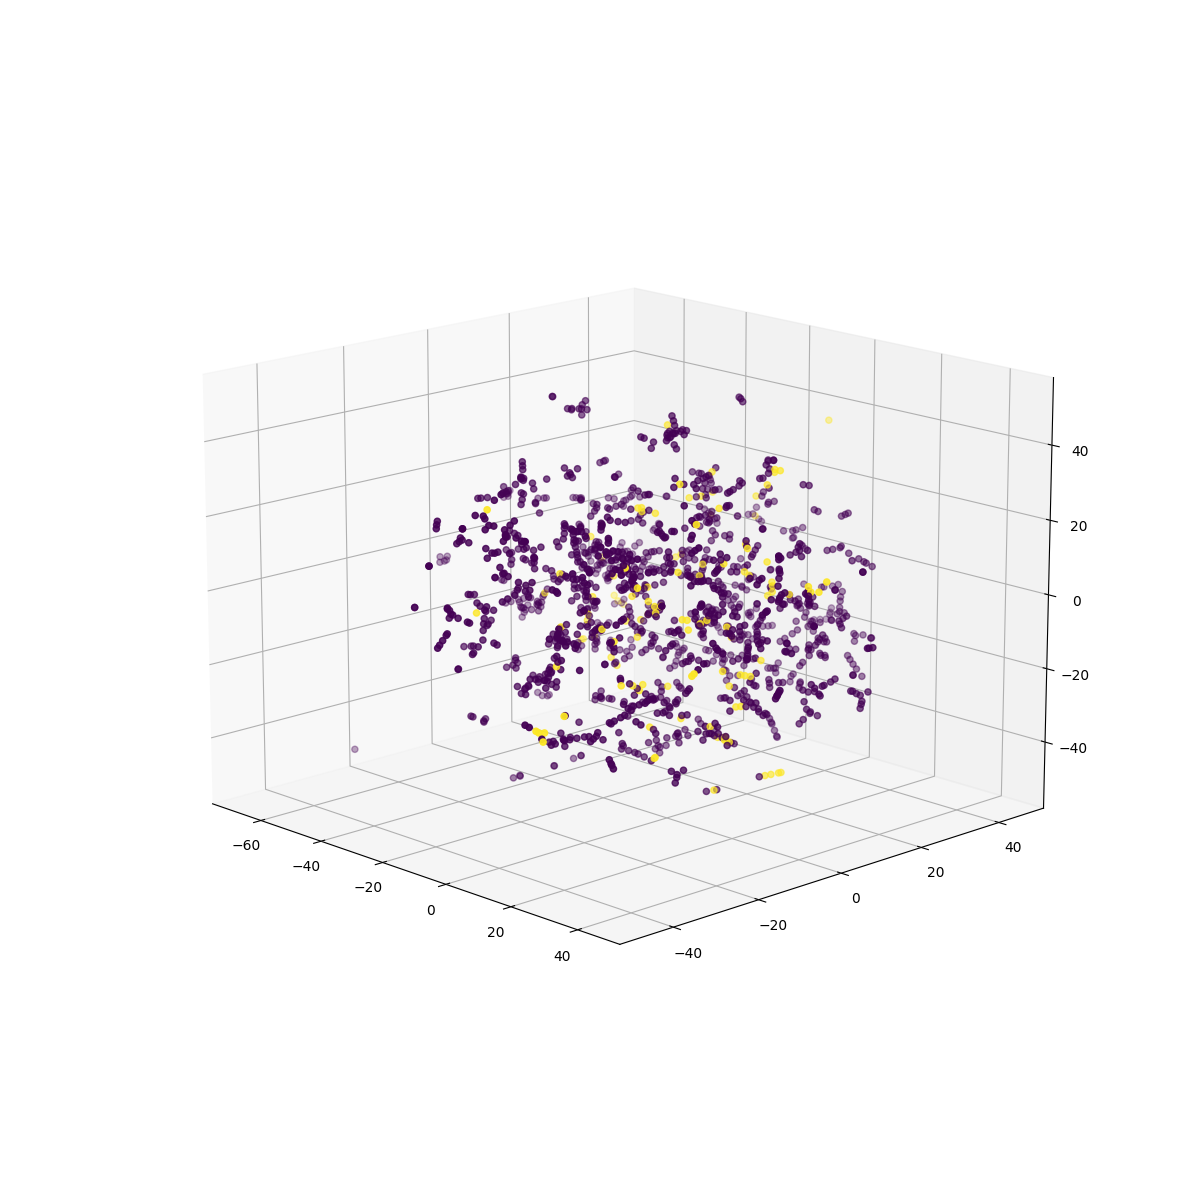

In [30]:
fig = plt.figure(figsize=(12,12))
axs = fig.add_subplot(111, projection='3d')

axs.scatter(
    df_res["tsne-3d-one"], df_res["tsne-3d-two"], df_res["tsne-3d-three"], c=df_res["y"]
)

### Plot

In [121]:
# max_sim_plot
diff12 = []
diff13 = []

for sid in sim_with_mcomp:
    diff12.append(sim_with_mcomp[sid]["max"] - sim_with_not_mcomp[sid]["max"])
    diff13.append(sim_with_mcomp[sid]["max"] - sim_with_notmcomp_paper_sents[sid]["max"])

v1 = round(sum(i > 0 for i in diff12)/len(diff12), 2)
v2 = round(sum(i > 0 for i in diff13)/len(diff13), 2)

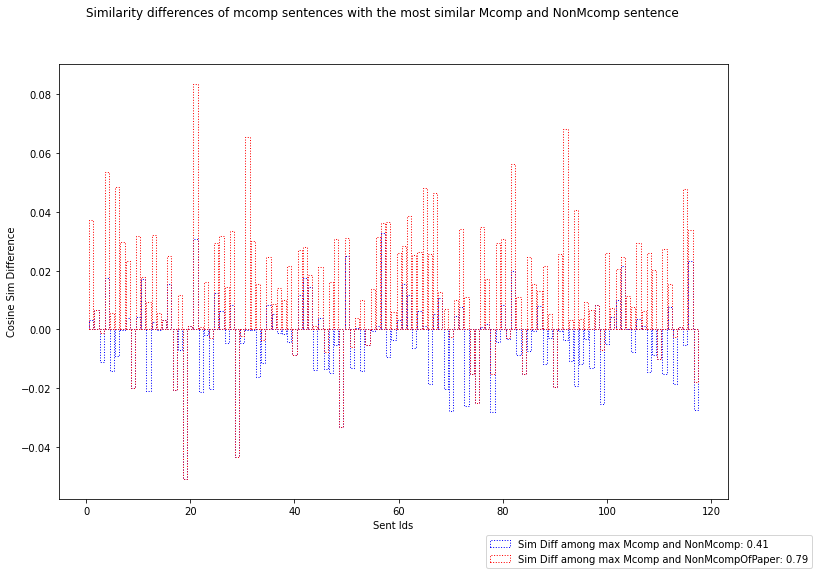

In [122]:
fig, axs = plt.subplots(1, 1, sharey=True, figsize=(12,8))

rects1 = axs.bar(list(range(1,len(diff12)+1)), diff12, fill=False, edgecolor='blue', linestyle='dotted', label="Sim Diff among max Mcomp and NonMcomp: {}".format(v1))
rects2 = axs.bar(list(range(1,len(diff13)+1)), diff13, fill=False, edgecolor='red', linestyle='dotted', label="Sim Diff among max Mcomp and NonMcompOfPaper: {}".format(v2))

fig.suptitle("Similarity differences of mcomp sentences with the most similar Mcomp and NonMcomp sentence")

handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

plt.setp(axs, xlabel="Sent Ids", ylabel="Cosine Sim Difference")

plt.savefig('plots/max_diff_sb.png', dpi=300)

In [123]:
# min_sim_plot
diff12 = []
diff13 = []

for sid in sim_with_mcomp:
    diff12.append(sim_with_mcomp[sid]["min"] - sim_with_not_mcomp[sid]["min"])
    diff13.append(sim_with_mcomp[sid]["min"] - sim_with_notmcomp_paper_sents[sid]["min"])

v1 = round(sum(i > 0 for i in diff12)/len(diff12), 2)
v2 = round(sum(i > 0 for i in diff13)/len(diff13), 2)

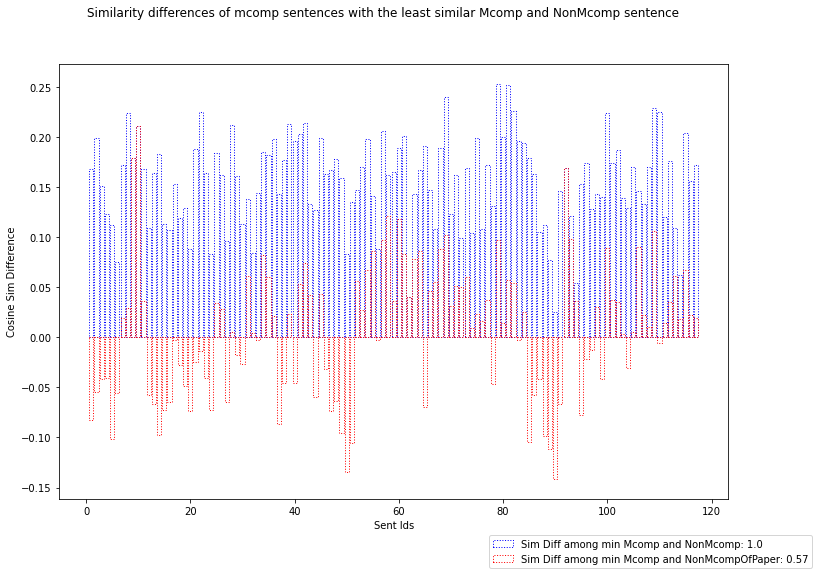

In [124]:
fig, axs = plt.subplots(1, 1, sharey=True, figsize=(12,8))

rects1 = axs.bar(list(range(1,len(diff12)+1)), diff12, fill=False, edgecolor='blue', linestyle='dotted', label="Sim Diff among min Mcomp and NonMcomp: {}".format(v1))
rects2 = axs.bar(list(range(1,len(diff13)+1)), diff13, fill=False, edgecolor='red', linestyle='dotted', label="Sim Diff among min Mcomp and NonMcompOfPaper: {}".format(v2))

fig.suptitle("Similarity differences of mcomp sentences with the least similar Mcomp and NonMcomp sentence")

handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')


plt.setp(axs, xlabel="Sent Ids", ylabel="Cosine Sim Difference")

plt.savefig('plots/min_diff_sb.png', dpi=300)

In [125]:
# mean_sim_plot
diff12 = []
diff13 = []

for sid in sim_with_mcomp:
    diff12.append(sim_with_mcomp[sid]["mean"] - sim_with_not_mcomp[sid]["mean"])
    diff13.append(sim_with_mcomp[sid]["mean"] - sim_with_notmcomp_paper_sents[sid]["mean"])

v1 = round(sum(i > 0 for i in diff12)/len(diff12), 2)
v2 = round(sum(i > 0 for i in diff13)/len(diff13), 2)

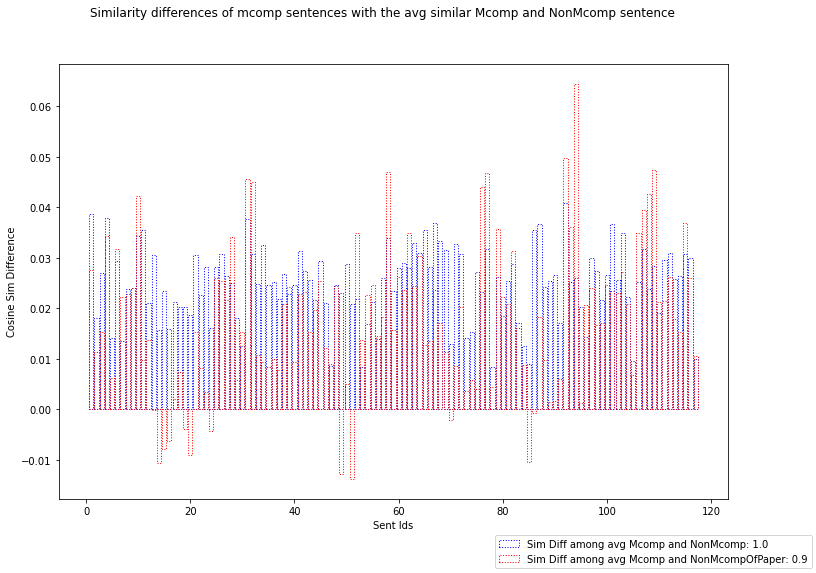

In [126]:
fig, axs = plt.subplots(1, 1, sharey=True, figsize=(12,8))

rects1 = axs.bar(list(range(1,len(diff12)+1)), diff12, fill=False, edgecolor='blue', linestyle='dotted', label="Sim Diff among avg Mcomp and NonMcomp: {}".format(v1))
rects2 = axs.bar(list(range(1,len(diff13)+1)), diff13, fill=False, edgecolor='red', linestyle='dotted', label="Sim Diff among avg Mcomp and NonMcompOfPaper: {}".format(v2))

fig.suptitle("Similarity differences of mcomp sentences with the avg similar Mcomp and NonMcomp sentence")

handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

plt.setp(axs, xlabel="Sent Ids", ylabel="Cosine Sim Difference")

plt.savefig('plots/mean_diff_sb.png', dpi=300)

# B. USE

In [10]:
import tensorflow as tf
import tensorflow_hub as hub

/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [11]:
embed_text_using_use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [15]:
use_vectors = defaultdict(dict)
skip_uids = [938, 940, 1425]

for pid in gt_dict:
    use_vectors[pid] = {}
    
    for mcs in gt_dict[pid]["mcomp"]:
        try:
            vec = embed_text_using_use([df.loc[mcs]["Sent"]])
            use_vectors[pid][mcs] = vec / norm(vec)
        except Exception as ex:
            print(pid, mcs, df.loc[mcs]["Sent"])
            skip_uids.append(mcs)
    
    for mcs in gt_dict[pid]["not_mcomp"]:
        if not mcs in [938, 940, 1425]:
            try:
                vec = embed_text_using_use([df.loc[mcs]["Sent"]])
                use_vectors[pid][mcs] = vec / norm(vec)
            except Exception as ex:
                print(pid, mcs, df.loc[mcs]["Sent"])
                skip_uids.append(mcs)
        

In [16]:
mcomp_sentences = {}
not_mcomp_sentences = {}

for pid in gt_dict:
    for mcs in gt_dict[pid]["mcomp"]:
        if not mcs in skip_uids:
            mcomp_sentences[mcs] = pid
    for mcs in gt_dict[pid]["not_mcomp"]:
        if not mcs in skip_uids:
            not_mcomp_sentences[mcs] = pid
print(len(mcomp_sentences), len(not_mcomp_sentences))

117 1385


In [17]:
sim_with_mcomp = defaultdict(dict)
sim_with_not_mcomp = defaultdict(dict)
sim_with_notmcomp_paper_sents = defaultdict(dict)
sim_with_mcomp_paper_sents = defaultdict(dict)

for sid in mcomp_sentences:
    
    # 1. With other mcomp sentences
    temp_list = []    
    for osid in mcomp_sentences:
        if osid != sid:
            temp_list.append(np.inner(use_vectors[mcomp_sentences[osid]][osid], use_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sim_with_mcomp[sid]["min"] = min(temp_list)
    sim_with_mcomp[sid]["max"] = max(temp_list)
    sim_with_mcomp[sid]["mean"] = np.mean(temp_list)
    
    
    # 2. With other not_mcomp_sentences
    temp_list = []
    for osid in not_mcomp_sentences:
        temp_list.append(np.inner(use_vectors[not_mcomp_sentences[osid]][osid], use_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sim_with_not_mcomp[sid]["min"] = min(temp_list)
    sim_with_not_mcomp[sid]["max"] = max(temp_list)
    sim_with_not_mcomp[sid]["mean"] = np.mean(temp_list)
    
    # 3. With not_mcomp_sentences of the same paper
    temp_list = []    
    for osid in not_mcomp_sentences:
        if not_mcomp_sentences[osid] == mcomp_sentences[sid]:
            temp_list.append(np.inner(use_vectors[not_mcomp_sentences[osid]][osid], use_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sim_with_notmcomp_paper_sents[sid]["min"] = min(temp_list)
    sim_with_notmcomp_paper_sents[sid]["max"] = max(temp_list)
    sim_with_notmcomp_paper_sents[sid]["mean"] = np.mean(temp_list)
    
    # 4. With mcomp_sentences of the same paper
    temp_list = []    
    for osid in mcomp_sentences:
        if mcomp_sentences[osid] == mcomp_sentences[sid] and osid!=sid:
            temp_list.append(np.inner(use_vectors[mcomp_sentences[osid]][osid], use_vectors[mcomp_sentences[sid]][sid])[0][0])
    if len(temp_list) > 0:
        sim_with_mcomp_paper_sents[sid]["min"] = min(temp_list)
        sim_with_mcomp_paper_sents[sid]["max"] = max(temp_list)
        sim_with_mcomp_paper_sents[sid]["mean"] = np.mean(temp_list)

### Plot

In [31]:
# max_sim_plot
diff12 = []
diff13 = []

for sid in sim_with_mcomp:
    diff12.append(sim_with_mcomp[sid]["max"] - sim_with_not_mcomp[sid]["max"])
    diff13.append(sim_with_mcomp[sid]["max"] - sim_with_notmcomp_paper_sents[sid]["max"])

v1 = round(sum(i > 0 for i in diff12)/len(diff12), 2)
v2 = round(sum(i > 0 for i in diff13)/len(diff13), 2)

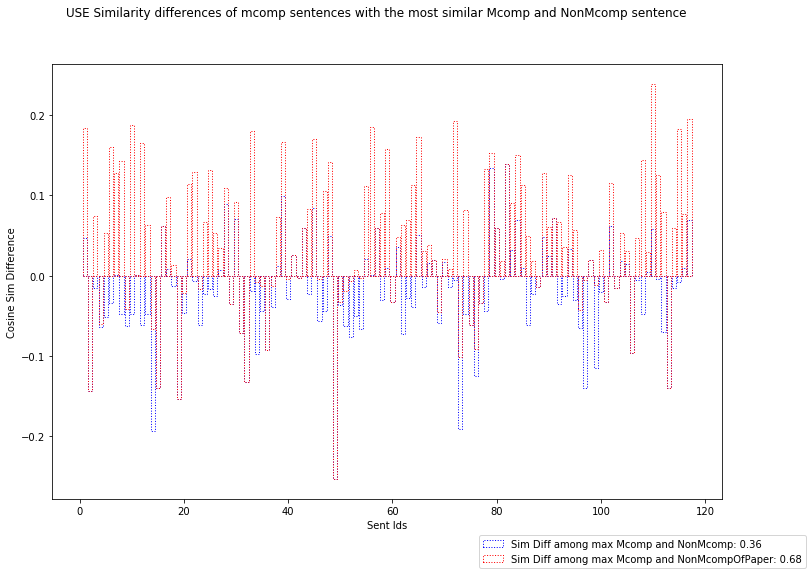

In [32]:
fig, axs = plt.subplots(1, 1, sharey=True, figsize=(12,8))

rects1 = axs.bar(list(range(1,len(diff12)+1)), diff12, fill=False, edgecolor='blue', linestyle='dotted', label="Sim Diff among max Mcomp and NonMcomp: {}".format(v1))
rects2 = axs.bar(list(range(1,len(diff13)+1)), diff13, fill=False, edgecolor='red', linestyle='dotted', label="Sim Diff among max Mcomp and NonMcompOfPaper: {}".format(v2))

fig.suptitle("USE Similarity differences of mcomp sentences with the most similar Mcomp and NonMcomp sentence")

handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

plt.setp(axs, xlabel="Sent Ids", ylabel="Cosine Sim Difference")

plt.savefig('plots/max_diff_USE.png', dpi=300)

In [33]:
# min_sim_plot
diff12 = []
diff13 = []

for sid in sim_with_mcomp:
    diff12.append(sim_with_mcomp[sid]["min"] - sim_with_not_mcomp[sid]["min"])
    diff13.append(sim_with_mcomp[sid]["min"] - sim_with_notmcomp_paper_sents[sid]["min"])

v1 = round(sum(i > 0 for i in diff12)/len(diff12), 2)
v2 = round(sum(i > 0 for i in diff13)/len(diff13), 2)

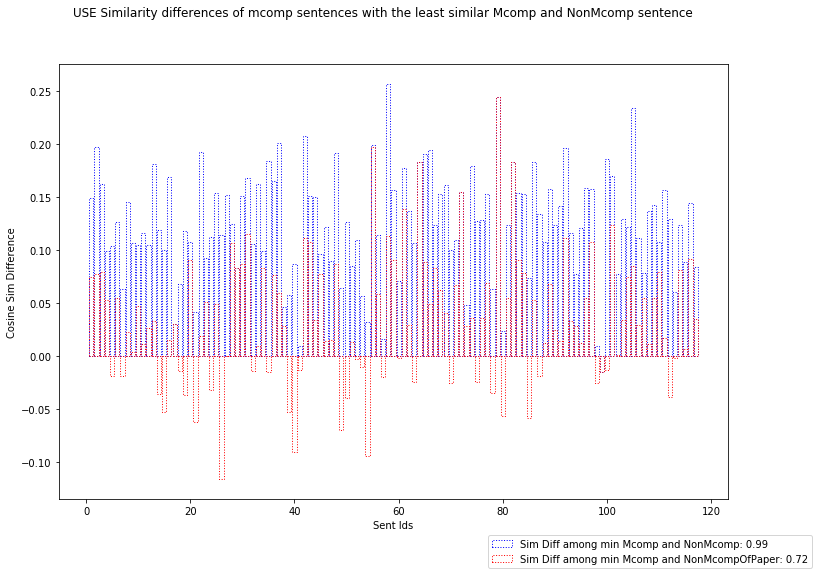

In [34]:
fig, axs = plt.subplots(1, 1, sharey=True, figsize=(12,8))

rects1 = axs.bar(list(range(1,len(diff12)+1)), diff12, fill=False, edgecolor='blue', linestyle='dotted', label="Sim Diff among min Mcomp and NonMcomp: {}".format(v1))
rects2 = axs.bar(list(range(1,len(diff13)+1)), diff13, fill=False, edgecolor='red', linestyle='dotted', label="Sim Diff among min Mcomp and NonMcompOfPaper: {}".format(v2))

fig.suptitle("USE Similarity differences of mcomp sentences with the least similar Mcomp and NonMcomp sentence")

handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')


plt.setp(axs, xlabel="Sent Ids", ylabel="Cosine Sim Difference")

plt.savefig('plots/min_diff_USE.png', dpi=300)

In [35]:
# mean_sim_plot
diff12 = []
diff13 = []

for sid in sim_with_mcomp:
    diff12.append(sim_with_mcomp[sid]["mean"] - sim_with_not_mcomp[sid]["mean"])
    diff13.append(sim_with_mcomp[sid]["mean"] - sim_with_notmcomp_paper_sents[sid]["mean"])

v1 = round(sum(i > 0 for i in diff12)/len(diff12), 2)
v2 = round(sum(i > 0 for i in diff13)/len(diff13), 2)

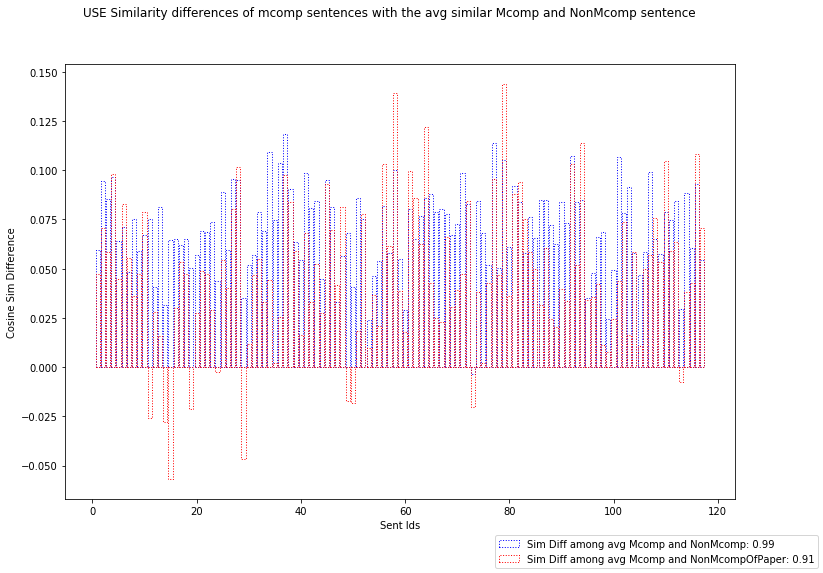

In [36]:
fig, axs = plt.subplots(1, 1, sharey=True, figsize=(12,8))

rects1 = axs.bar(list(range(1,len(diff12)+1)), diff12, fill=False, edgecolor='blue', linestyle='dotted', label="Sim Diff among avg Mcomp and NonMcomp: {}".format(v1))
rects2 = axs.bar(list(range(1,len(diff13)+1)), diff13, fill=False, edgecolor='red', linestyle='dotted', label="Sim Diff among avg Mcomp and NonMcompOfPaper: {}".format(v2))

fig.suptitle("USE Similarity differences of mcomp sentences with the avg similar Mcomp and NonMcomp sentence")

handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

plt.setp(axs, xlabel="Sent Ids", ylabel="Cosine Sim Difference")

plt.savefig('plots/mean_diff_USE.png', dpi=300)